# Casing Example:

- Downhole magnetic dipole source
- Highly conductive casing, which also has a significant magnetic permeability 
- Solve Maxwell's equations using a finite volume approach on a cylindrical mesh

Requirements:
- SimPEG: https://github.com/simpeg/simpeg (pip install SimPEG)
- simpegEM: https://github.com/simpeg/simpegem (sorry, it's not on pypi yet...) 

In [16]:
from SimPEG import *
import simpegEM as EM
from scipy.constants import mu_0
from matplotlib import pyplot as plt
%matplotlib inline

# Model Parameters

In [17]:
# Model Resistivities (Ohm-m) 
rhoback = 10. # background
rhoair = 1e8 # air
rhocasing = 1./5.5e6 # conductivity of carbon steel
rhoinside = 1. # conductivity of fluid filling well (Commer et al uses 0.3333 S/m)

# relative permeability (only of casing --> the rest is mu_0) 
murback = 1. 
murcasing = 100. # permeability of casing

# casing parameters
d = 10e-2 # 10cm diameter casing
t = 1e-2  # 1cm thickness 
casing_a = d/2.
casing_b = d/2. + t
zcasing = [-1000., 0.]

# Survey Params
freq = 30.  # frequency in hertz
dsz = -900. # down-hole z source location

skdpth = (500./np.sqrt(1./rhoback*freq))
print 'Skin Depth: ',skdpth 

Skin Depth:  288.675134595


# Mesh

Make sure it is large enough that the fields have sufficiently decayed by the boundary

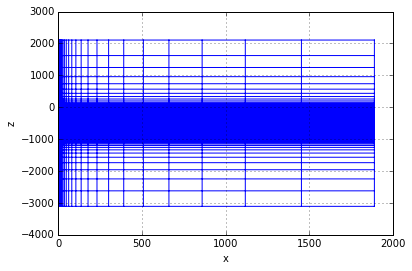

In [18]:
csx, csz = 2.5e-3, 0.05 # core cell size in x,z directions
ncx, npadxi, npadxo = np.ceil((d/2.+t)/csx+5), 0, 46 # number of core cells, number of padding cells in the x- direction
ncz, npadzu, npadzd = np.ceil(-zcasing[0]/csz+10), 35, 35 # number of core cells, number of padding cells in the x- direction

hx = Utils.meshTensor([(csx,ncx), (csx,npadxo,1.3)]) # vector of cell widths in the x-direction
hz = Utils.meshTensor([(csz,npadzd,-1.3), (csz,ncz), (csz,npadzu,1.3)]) # vector of cell widths in the z-direction
meshp = Mesh.CylMesh([hx,1,hz], [0.,0.,-np.sum(hz[:npadzu+ncz-5])]) # define the cylindrical mesh

# Plot the Mesh
meshp.plotGrid()

# Put Model on Mesh

In [19]:
# background
RhoBack = rhoback*np.ones((meshp.nC)) # primary sigma on primary mesh  
MuBack  = murback*np.ones((meshp.nC)) # primary mur on primary mesh

# air
iAir          = meshp.gridCC[:,2] >= 0.
RhoBack[iAir] = rhoair

RhoCasing = RhoBack.copy()
MuCasing = MuBack.copy()

# Inside casing
iInsideX = meshp.gridCC[:,0] < d/2.
iInsideZ = (meshp.gridCC[:,2] >= zcasing[0]) & (meshp.gridCC[:,2] <= zcasing[1])
iInside = iInsideX & iInsideZ
RhoCasing[iInside] = rhoinside

# Casing
iCasingX = (meshp.gridCC[:,0] >= d/2.) & (meshp.gridCC[:,0] <= d/2.+t)
iCasingZ = iInsideZ
iCasing = iCasingX & iCasingZ
RhoCasing[iCasing] = rhocasing
MuCasing[iCasing] = murcasing

# use mu not mur 
MuBack   = mu_0*MuBack
MuCasing = mu_0*MuCasing

[]

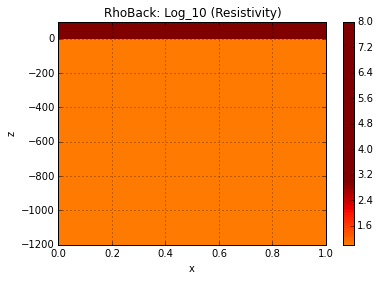

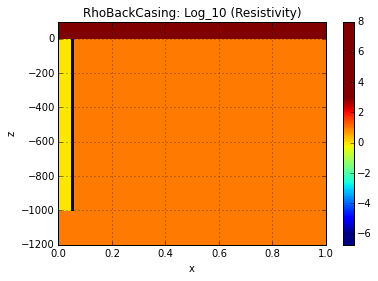

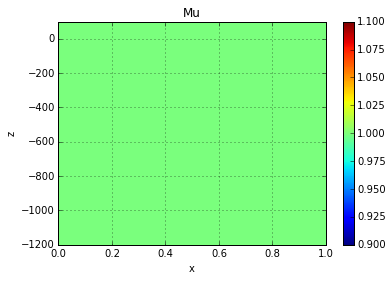

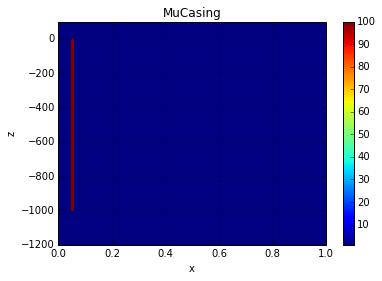

In [20]:
# Plot Resistivity Model : note cyl symmetric mesh: rotate around r = 0
xlim = [0., 1.]
ylim = [-1200., 100.]
clim = [-6.,3.]

# rhoback
f = plt.colorbar(meshp.plotImage(np.log10(RhoBack))[0])
f.set_clim(clim[0],clim[1])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('RhoBack: Log_10 (Resistivity)')
plt.plot()

# rhoCasing
f = plt.colorbar(meshp.plotImage(np.log10(RhoCasing))[0])
f.set_clim(clim[0],clim[1])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('RhoBackCasing: Log_10 (Resistivity)')
plt.plot()

# Plot Rel Permeability Model
plt.colorbar(meshp.plotImage(MuBack/mu_0)[0])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('Mu')
plt.plot()

# Plot Rel Permeability Model
plt.colorbar(meshp.plotImage(MuCasing/mu_0)[0])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('MuCasing')
plt.plot()

# Survey

In [21]:
# point sources
src_loc = np.r_[0.,0.,dsz]
s_ind = Utils.closestPoints(meshp,src_loc,'Fz') + meshp.nFx

# Mag dipole from vector potential downhole
dmSrcList = []
dmSrcList.append(EM.FDEM.SrcFDEM_MagDipole([],freq,src_loc))

In [22]:
# Pair the problem and survey
mapping = [('rho', Maps.IdentityMap(meshp)),('mu', Maps.IdentityMap(meshp))] # create mapping to use variable mu and variable sigma

surveym = EM.FDEM.SurveyFDEM(dmSrcList)
prbm = EM.FDEM.ProblemFDEM_e(meshp, mapping=mapping)
prbm.pair(surveym)
prbm.solver = SolverLU


# Solve

In [23]:
%%time

# Solve Maxwell on a cyl mesh for 3 different models

fieldsBack = prbm.fields(np.r_[RhoBack,MuBack]) # background only
fieldsCasingMu0 = prbm.fields(np.r_[RhoCasing, MuBack]) # conductive casing
fieldsCasingMu = prbm.fields(np.r_[RhoCasing, MuCasing]) # conductive, permeable casing

CPU times: user 40.5 s, sys: 8.27 s, total: 48.7 s
Wall time: 50.6 s


## Plot

In [24]:
# line where we are evaluating
r = 90. 
z = np.linspace(-1200.,-600.,1000)

In [25]:
XYZ = Utils.ndgrid(np.r_[r], np.r_[0], z)

Pfz = meshp.getInterpolationMat(XYZ, 'Fz')
Pfx = meshp.getInterpolationMat(XYZ, 'Fx')

bBack = fieldsBack[dmSrcList[0],'b']
bCasingMu0 = fieldsCasingMu0[dmSrcList[0],'b']
bCasingMu = fieldsCasingMu[dmSrcList[0],'b']

bxBack, bzBack = Pfx*bBack, Pfz*bBack
bxCasingMu0, bzCasingMu0 = Pfx*bCasingMu0, Pfz*bCasingMu0
bxCasingMu, bzCasingMu = Pfx*bCasingMu, Pfz*bCasingMu

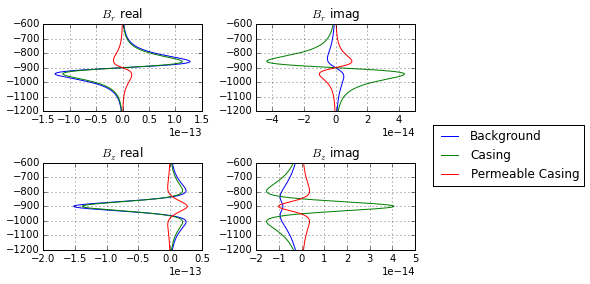

In [26]:
# Plot Magnetic Fields
plt.subplot(221)
plt.plot(bxBack.real,z,bxCasingMu0.real,z,bxCasingMu.real,z)
plt.grid(which='both')
plt.title('$B_r$ real')

plt.subplot(222)
plt.plot(bxBack.imag,z,bxCasingMu0.imag,z,bxCasingMu.imag,z)
plt.grid(which='both')
plt.title('$B_r$ imag')

plt.subplot(223)
plt.plot(bzBack.real,z,bzCasingMu0.real,z,bzCasingMu.real,z)
plt.grid(which='both')
plt.title('$B_z$ real')

plt.subplot(224)
plt.plot(bzBack.imag,z,bzCasingMu0.imag,z,bzCasingMu.imag,z)
plt.grid(which='both')
plt.title('$B_z$ imag')
plt.legend(['Background','Casing', 'Permeable Casing'],bbox_to_anchor=(2.1,1.5))

plt.tight_layout()

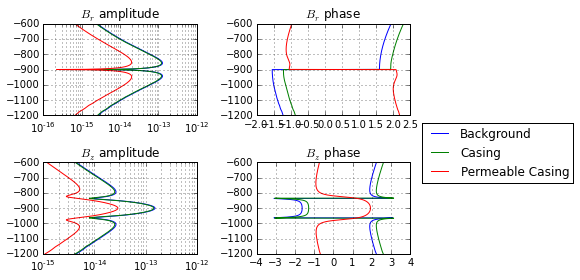

In [27]:
# Plot Magnetic Fields
plt.subplot(221)
plt.semilogx(np.absolute(bxBack),z,np.absolute(bxCasingMu0),z,np.absolute(bxCasingMu),z)
plt.grid(which='both')
plt.title('$B_r$ amplitude')

plt.subplot(222)
plt.plot(np.arctan2(bxBack.real,bxBack.imag),z,np.arctan2(bxCasingMu0.real,bxCasingMu0.imag),z,np.arctan2(bxCasingMu.real,bxCasingMu.imag),z)
plt.grid(which='both')
plt.title('$B_r$ phase')

plt.subplot(223)
plt.semilogx(np.absolute(bzBack),z,np.absolute(bzCasingMu0),z,np.absolute(bzCasingMu),z)
plt.grid(which='both')
plt.title('$B_z$ amplitude')

plt.subplot(224)
plt.plot(np.arctan2(bzBack.real,bzBack.imag),z,np.arctan2(bzCasingMu0.real,bzCasingMu0.imag),z,np.arctan2(bzCasingMu.real,bzCasingMu.imag),z)
plt.grid(which='both')
plt.title('$B_z$ phase')
plt.legend(['Background','Casing', 'Permeable Casing'],bbox_to_anchor=(2.1,1.5))

plt.tight_layout()